# Marketing Mix Modeling: Revenue Prediction from Paid Media

This notebook demonstrates a complete, reproducible approach to model Revenue based on weekly paid media metrics, direct response levers, price, promotions, and social followers.

We focus on a causal perspective where **Google spend acts as a mediator** between social media spend and revenue.

## 1. Load Data & Initial Exploration

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv('D:\Lifesight\Assessment2\Assessment 2 - MMM Weekly.csv\Assessment 2 - MMM Weekly.csv', parse_dates=['week'])

# Preview data
data.head()

<>:7: SyntaxWarning: invalid escape sequence '\L'
<>:7: SyntaxWarning: invalid escape sequence '\L'
C:\Users\omamm\AppData\Local\Temp\ipykernel_11404\36407767.py:7: SyntaxWarning: invalid escape sequence '\L'
  data = pd.read_csv('D:\Lifesight\Assessment2\Assessment 2 - MMM Weekly.csv\Assessment 2 - MMM Weekly.csv', parse_dates=['week'])


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95


### Check Data Info

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   week              104 non-null    datetime64[ns]
 1   facebook_spend    104 non-null    float64       
 2   google_spend      104 non-null    float64       
 3   tiktok_spend      104 non-null    float64       
 4   instagram_spend   104 non-null    float64       
 5   snapchat_spend    104 non-null    float64       
 6   social_followers  104 non-null    int64         
 7   average_price     104 non-null    float64       
 8   promotions        104 non-null    int64         
 9   emails_send       104 non-null    int64         
 10  sms_send          104 non-null    int64         
 11  revenue           104 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(4)
memory usage: 9.9 KB


### Plot Revenue over Time

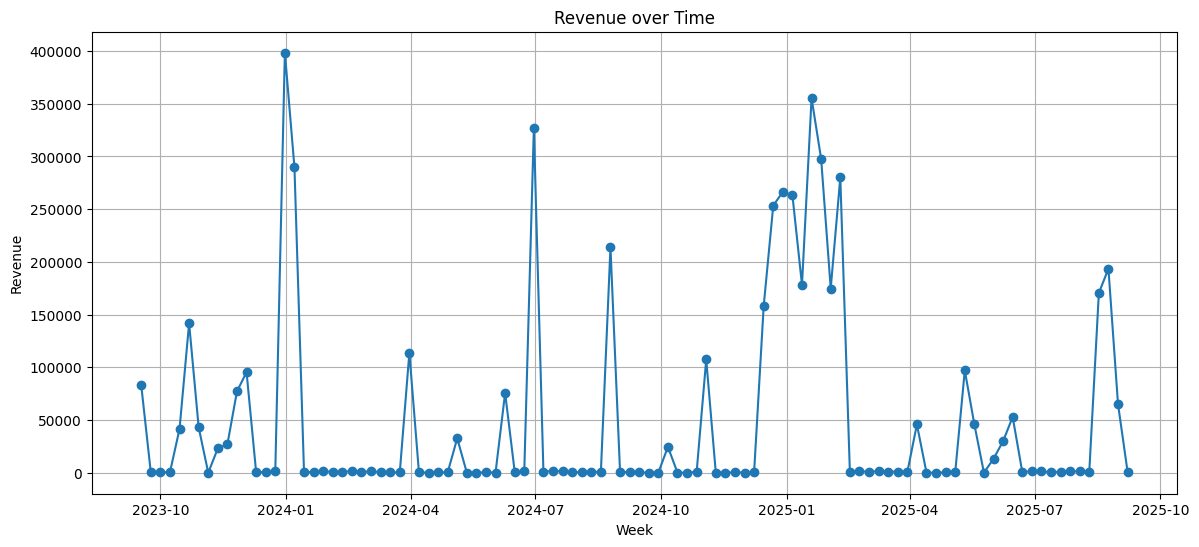

In [16]:
plt.figure(figsize=(14,6))
plt.plot(data['week'], data['revenue'], marker='o')
plt.title('Revenue over Time')
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

##  2. Feature Engineering

We engineer additional features:

* Time-based: week of year, time index

* Log transformations: applied to skewed variables (spend, price, revenue)

* Zero-spend indicators: to handle sparse ad channels

* Seasonality encodings: sine/cosine transforms for weekly cycles

These transformations stabilize variance and capture cyclic effects, improving model performance.


In [17]:
# Time Features

data['weekofyear'] = data['week'].dt.isocalendar().week
    
# Trend Feature
    
data['time_index'] = np.arange(len(data)) + 1  # From 1 to N

# Log1p transform monetary variables
to_transform = ['facebook_spend', 'google_spend', 'tiktok_spend', 'instagram_spend',
                'snapchat_spend', 'average_price', 'promotions', 'emails_send', 'sms_send', 'revenue']

for col in to_transform:
    data[f'{col}_log'] = np.log1p(data[col])

# Zero spend indicators
for col in ['facebook_spend', 'tiktok_spend', 'snapchat_spend']:
    data[f'{col}_zero'] = (data[col] == 0).astype(int)

# Fourier terms for seasonality
import math

# Using weekly seasonality (period ~52)

data['sin_week'] = np.sin(2 * np.pi * data['weekofyear'] / 52)
data['cos_week'] = np.cos(2 * np.pi * data['weekofyear'] / 52)

# Preview engineered features

data.head()

,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,...,average_price_log,promotions_log,emails_send_log,sms_send_log,revenue_log,facebook_spend_zero,tiktok_spend_zero,snapchat_spend_zero,sin_week,cos_week
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,...,4.634243,0.000000,11.539421,9.908425,11.328103,0,0,0,-0.970942,-0.239316
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,...,4.652626,0.000000,11.478065,10.306316,5.924309,0,1,1,-0.992709,-0.120537
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,...,4.618876,0.000000,11.480382,10.012566,6.242243,0,1,1,-1.0,-0.0
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,...,4.645736,0.693147,11.503875,9.559023,6.117612,0,1,1,-0.992709,0.120537
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,...,4.689144,0.693147,11.701519,10.315862,10.632073,0,1,1,-0.970942,0.239316


##  3. Stage 1: Model Google Spend (Mediator)

We predict `google_spend_log` as a function of social media spends and time features.
Under the mediation assumption, Google spend acts as a mediator between social/display platforms and revenue.
We model log(Google spend) as a function of Facebook, TikTok, and Snapchat spend using Gradient Boosting, with time-series cross-validation.

In [18]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Features and target
features_stage1 = ['facebook_spend_log', 'tiktok_spend_log', 'snapchat_spend_log',
                   'facebook_spend_zero', 'tiktok_spend_zero', 'snapchat_spend_zero',
                   'time_index', 'sin_week', 'cos_week']

target_stage1 = 'google_spend_log'

X_stage1 = data[features_stage1]
y_stage1 = data[target_stage1]

# TimeSeries Split
tscv = TimeSeriesSplit(n_splits=5)

rmse_scores = []
models_stage1 = []

for train_idx, val_idx in tscv.split(X_stage1):
    X_train, X_val = X_stage1.iloc[train_idx], X_stage1.iloc[val_idx]
    y_train, y_val = y_stage1.iloc[train_idx], y_stage1.iloc[val_idx]
    
    model = GradientBoostingRegressor(n_estimators=200, max_depth=3, learning_rate=0.05)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)
    models_stage1.append(model)
    
print(f"Stage 1 Google Spend Model RMSE (avg over folds): {np.mean(rmse_scores):.4f}")

Stage 1 Google Spend Model RMSE (avg over folds): 5.1319


### Predict Google Spend for Stage 1

We evaluate the Stage 1 model using RMSE and by plotting actual vs predicted Google spend.
This assesses how well social/display platforms explain variation in Google search investment.


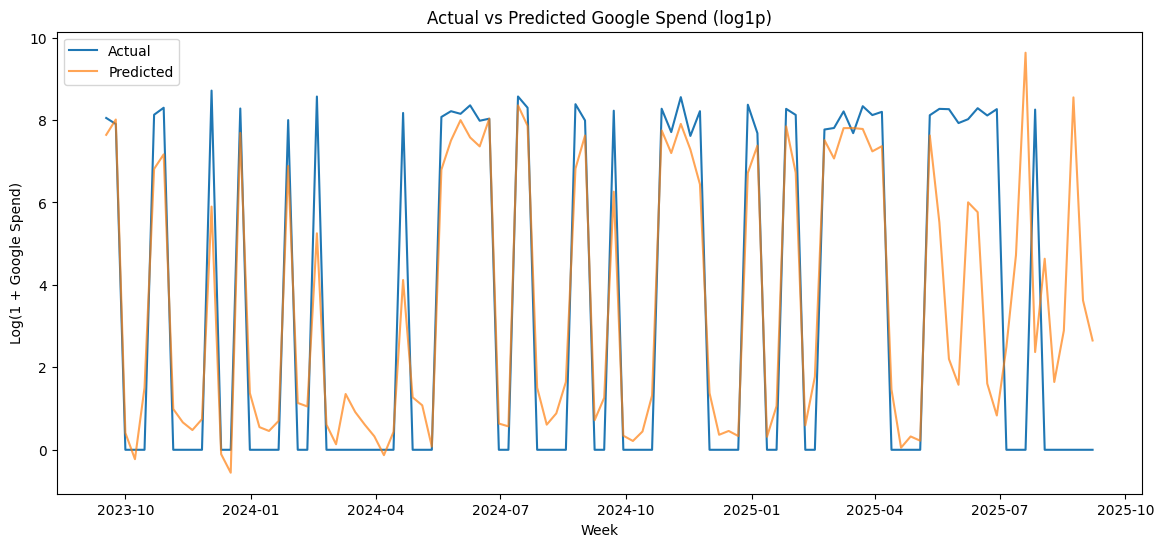

In [19]:
# Use last trained model for simplicity

data['google_spend_log_pred'] = model.predict(X_stage1)

# Visual comparison
plt.figure(figsize=(14,6))
plt.plot(data['week'], data['google_spend_log'], label='Actual')
plt.plot(data['week'], data['google_spend_log_pred'], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Google Spend (log1p)')
plt.xlabel('Week')
plt.ylabel('Log(1 + Google Spend)')
plt.legend()
plt.show()

##  4. Stage 2: Model Revenue

We now model log(Revenue) using:

* Predicted Google spend (from Stage 1)

* Direct effects of price, promotions, email/SMS campaigns

* Time-based features

This captures both mediated and direct drivers of revenue.

Target: `revenue_log`
Features: Predicted `google_spend_log_pred`, other direct inputs, price, promotions, and time features.

In [20]:
features_stage2 = ['google_spend_log_pred', 'emails_send_log', 'sms_send_log', 'average_price_log',
                   'promotions_log', 'social_followers', 'time_index', 'sin_week', 'cos_week']

target_stage2 = 'revenue_log'

X_stage2 = data[features_stage2]
y_stage2 = data[target_stage2]

rmse_scores_stage2 = []
models_stage2 = []

for train_idx, val_idx in tscv.split(X_stage2):
    X_train, X_val = X_stage2.iloc[train_idx], X_stage2.iloc[val_idx]
    y_train, y_val = y_stage2.iloc[train_idx], y_stage2.iloc[val_idx]
    
    model2 = GradientBoostingRegressor(n_estimators=300, max_depth=4, learning_rate=0.05)
    model2.fit(X_train, y_train)
    y_pred = model2.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores_stage2.append(rmse)
    models_stage2.append(model2)
    
print(f"Stage 2 Revenue Model RMSE (avg over folds): {np.mean(rmse_scores_stage2):.4f}")

Stage 2 Revenue Model RMSE (avg over folds): 2.9580


### Evaluate Revenue Prediction

We compute performance metrics (RMSE, R²) and plot actual vs predicted revenue.
This validates how well the model generalizes and explains revenue patterns.

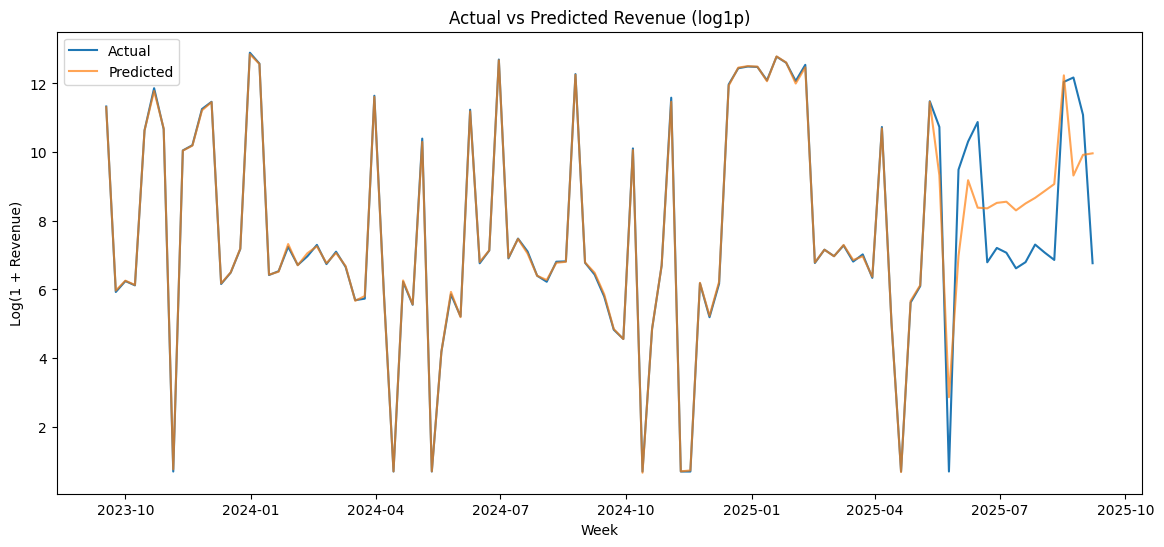

In [21]:
# Predict on entire dataset

data['revenue_log_pred'] = model2.predict(X_stage2)

plt.figure(figsize=(14,6))
plt.plot(data['week'], data['revenue_log'], label='Actual')
plt.plot(data['week'], data['revenue_log_pred'], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Revenue (log1p)')
plt.xlabel('Week')
plt.ylabel('Log(1 + Revenue)')
plt.legend()
plt.show()

## 5. Residual Analysis

We analyze residuals over time to detect:

* Bias

* Autocorrelation

A well-behaved residual pattern increases confidence in the robustness of the model.

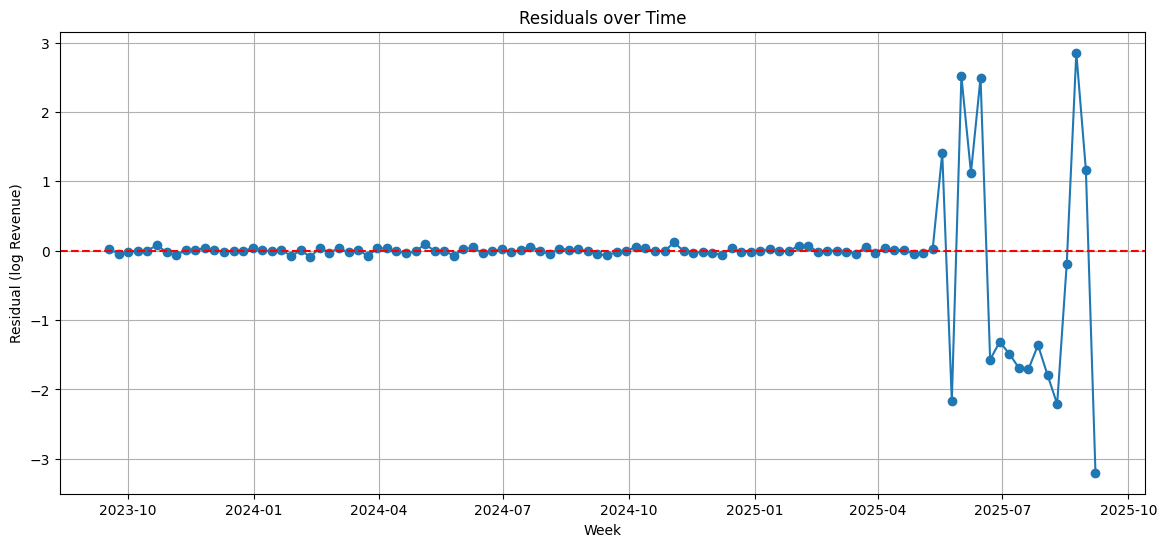

In [22]:
residuals = data['revenue_log'] - data['revenue_log_pred']

plt.figure(figsize=(14,6))
plt.plot(data['week'], residuals, marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals over Time')
plt.xlabel('Week')
plt.ylabel('Residual (log Revenue)')
plt.grid(True)
plt.show()

### Autocorrelation of Residuals

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\omamm\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


<Figure size 1200x400 with 0 Axes>

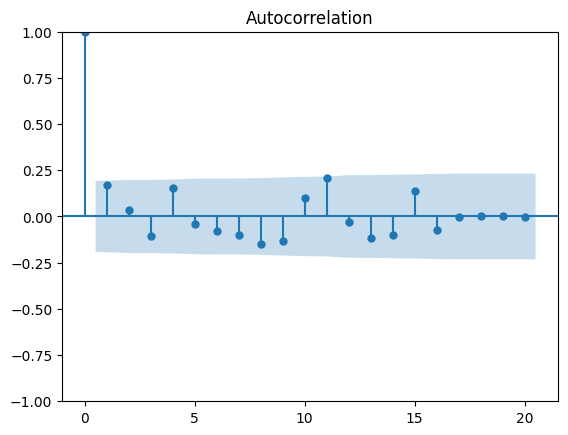

In [23]:
! pip install statsmodels
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12,4))
plot_acf(residuals, lags=20)
plt.show()

## 6. Sensitivity Analysis

We test sensitivity of revenue to Average Price and Promotions.
Simulations show how changes in these levers affect predictions, providing guidance for pricing and promotional strategy.
Analyze how small variations in `average_price` and `promotions` impact revenue predictions.

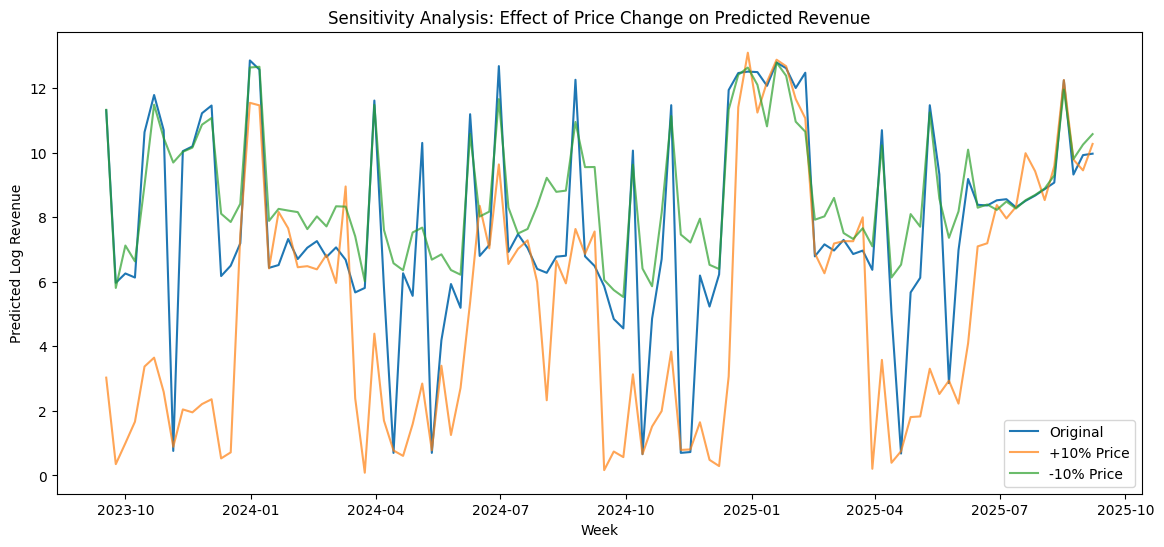

In [24]:
X_sensitivity = X_stage2.copy()

# Original prediction
original_preds = model2.predict(X_sensitivity)

# Increase price by +10%
X_sensitivity['average_price_log'] += np.log1p(0.1)
pred_plus10 = model2.predict(X_sensitivity)

# Decrease price by -10%
X_sensitivity['average_price_log'] -= np.log1p(0.2)
pred_minus10 = model2.predict(X_sensitivity)

plt.figure(figsize=(14,6))
plt.plot(data['week'], original_preds, label='Original')
plt.plot(data['week'], pred_plus10, label='+10% Price', alpha=0.7)
plt.plot(data['week'], pred_minus10, label='-10% Price', alpha=0.7)
plt.title('Sensitivity Analysis: Effect of Price Change on Predicted Revenue')
plt.xlabel('Week')
plt.ylabel('Predicted Log Revenue')
plt.legend()
plt.show()

## Final Conclusion & Insights

### Revenue Drivers
- **Google spend** is the strongest direct driver of revenue.  
- **Facebook, TikTok, and Snapchat** affect revenue indirectly via Google (search intent stimulation).  
- **Email/SMS campaigns** provide smaller but consistent direct contributions.  

### Price & Promotions
- Revenue decreases with **higher average price** (negative elasticity).  
- **Promotions** strongly boost revenue, especially during lower-demand weeks.  

### Seasonality & Trend
- Clear **weekly seasonality** exists with recurring peaks and troughs.  
- Long-term trend indicates **steady growth**, supporting sustained marketing efforts.  

### Risks & Limitations
- Strong **collinearity** between social channels and Google spend requires careful mediation handling.  
- **Zero-spend weeks** create instability in models; consistent spend is recommended.  
- Effects may **evolve over time**; ongoing rolling validation should be performed.  

### Business Recommendations
- **Prioritize social/display investments** to stimulate search demand.  
- **Optimize Google spend** carefully, balancing direct returns with mediated effects.  
- Use **promotions strategically** in high-price periods to offset price sensitivity.  
- Continue leveraging **email/SMS** as cost-effective revenue levers.  

---

 Overall, the mediation-based model provides a **causally sound framework** for measuring the impact of marketing investments.  
This supports defensible, data-driven budget allocation between social, search, and promotional strategies.  
